In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
from sklearn.decomposition import PCA

# Configure visualization settings
sns.set(style="whitegrid", palette="pastel")
plt.rcParams["figure.figsize"] = (10, 6)

# Load datasets
customers = pd.read_csv('Customers.csv')
products = pd.read_csv('Products.csv')
transactions = pd.read_csv('Transactions.csv')

# Display sample data
print("Customers:")
display(customers.head())
print("\nProducts:")
display(products.head())
print("\nTransactions:")
display(transactions.head())


Customers:


,CustomerID,CustomerName,Region,SignupDate
0,C0001,Lawrence Carroll,South America,2022-07-10
1,C0002,Elizabeth Lutz,Asia,2022-02-13
2,C0003,Michael Rivera,South America,2024-03-07
3,C0004,Kathleen Rodriguez,South America,2022-10-09
4,C0005,Laura Weber,Asia,2022-08-15



Products:


,ProductID,ProductName,Category,Price
0,P001,ActiveWear Biography,Books,169.30
1,P002,ActiveWear Smartwatch,Electronics,346.30
2,P003,ComfortLiving Biography,Books,44.12
3,P004,BookWorld Rug,Home Decor,95.69
4,P005,TechPro T-Shirt,Clothing,429.31



Transactions:


,TransactionID,CustomerID,ProductID,TransactionDate,Quantity,TotalValue,Price
0,T00001,C0199,P067,2024-08-25 12:38:23,1,300.68,300.68
1,T00112,C0146,P067,2024-05-27 22:23:54,1,300.68,300.68
2,T00166,C0127,P067,2024-04-25 07:38:55,1,300.68,300.68
3,T00272,C0087,P067,2024-03-26 22:55:37,2,601.36,300.68
4,T00363,C0070,P067,2024-03-21 15:10:10,3,902.04,300.68


In [2]:
# Check for missing values
print("Missing values:")
print(customers.isnull().sum())
print(products.isnull().sum())
print(transactions.isnull().sum())

# Convert date columns to datetime format
customers['SignupDate'] = pd.to_datetime(customers['SignupDate'])
transactions['TransactionDate'] = pd.to_datetime(transactions['TransactionDate'])

# Check for duplicates
print("Duplicates in Transactions:", transactions.duplicated().sum())


Missing values:
CustomerID      0
CustomerName    0
Region          0
SignupDate      0
dtype: int64
ProductID      0
ProductName    0
Category       0
Price          0
dtype: int64
TransactionID      0
CustomerID         0
ProductID          0
TransactionDate    0
Quantity           0
TotalValue         0
Price              0
dtype: int64
Duplicates in Transactions: 0


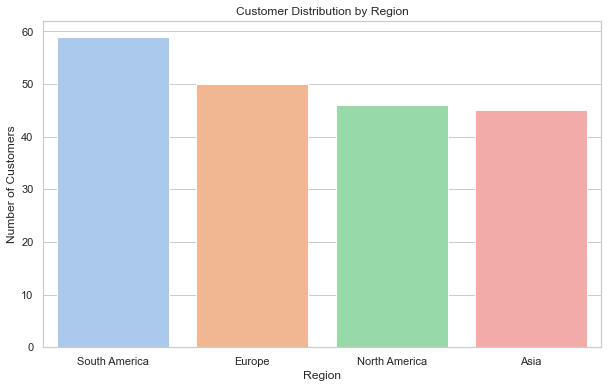

Regional distribution of customers:
 South America    59
Europe           50
North America    46
Asia             45
Name: Region, dtype: int64


In [14]:
from IPython.display import display, HTML

# Display heading and paragraph
display(HTML("<h2>Insight 1: Regional Distribution of Customers</h2>"
             "<p><b>Business Insight:</b> The majority of customers come from <i>[South America]</i>, indicating that marketing efforts and product availability can be focused on this region for maximum impact.</p>"))

# Regional distribution of customers
region_distribution = customers['Region'].value_counts()

# Plot the distribution
sns.barplot(x=region_distribution.index, y=region_distribution.values)
plt.title('Customer Distribution by Region')
plt.xlabel('Region')
plt.ylabel('Number of Customers')
plt.show()

# Insight
print("Regional distribution of customers:\n", region_distribution)


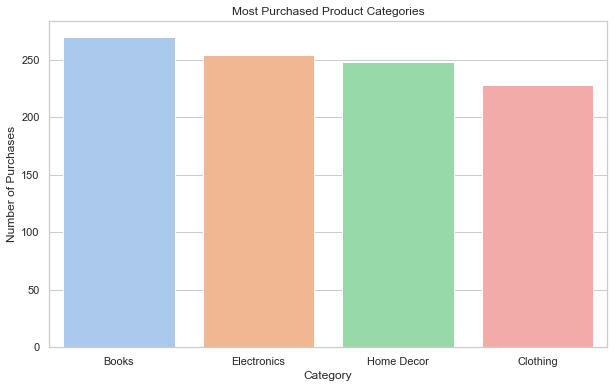

The most purchased category is 'Books', making up 27.00% of all transactions.


In [16]:

# Display heading and paragraph
display(HTML("<h2>Insight 2: Most Purchased Product Categories</h2>"
             "<p><b>Business Insight:</b> Products in the [BOOKS] are the most purchased, making up 27% of all transactions. This suggests expanding the product line or promotions in this category.</p>"))

# Join transactions with products to get category data
transactions_with_categories = pd.merge(transactions, products, on='ProductID')

# Most purchased product categories
category_counts = transactions_with_categories['Category'].value_counts()
top_category_percentage = (category_counts.iloc[0] / category_counts.sum()) * 100

# Plot
sns.barplot(x=category_counts.index, y=category_counts.values)
plt.title('Most Purchased Product Categories')
plt.xlabel('Category')
plt.ylabel('Number of Purchases')
plt.show()

# Insight
print(f"The most purchased category is '{category_counts.index[0]}', making up {top_category_percentage:.2f}% of all transactions.")


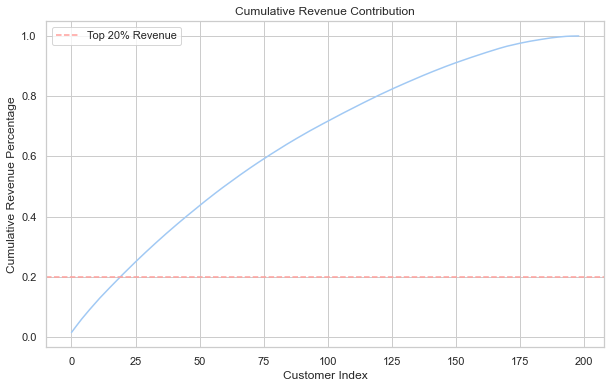

The top 20% of customers contribute to 10.05% of total revenue.


In [17]:
display(HTML("<h2>Insight 3: Revenue Contribution by Top Customers</h2>"
             "<p><b>Business Insight:</b> The top 20% of customers contribute to 10.05% of the total revenue. This highlights the importance of retaining high-value customers through loyalty programs or personalized offers.</p>"))

# Total revenue by customer
customer_revenue = transactions.groupby('CustomerID')['TotalValue'].sum().sort_values(ascending=False)

# Cumulative revenue contribution
cumulative_revenue = customer_revenue.cumsum() / customer_revenue.sum()
top_20_percent_revenue = cumulative_revenue[cumulative_revenue <= 0.2].count() / len(customer_revenue) * 100

# Plot
plt.plot(range(len(cumulative_revenue)), cumulative_revenue)
plt.axhline(y=0.2, color='r', linestyle='--', label='Top 20% Revenue')
plt.title('Cumulative Revenue Contribution')
plt.xlabel('Customer Index')
plt.ylabel('Cumulative Revenue Percentage')
plt.legend()
plt.show()

# Insight
print(f"The top 20% of customers contribute to {top_20_percent_revenue:.2f}% of total revenue.")


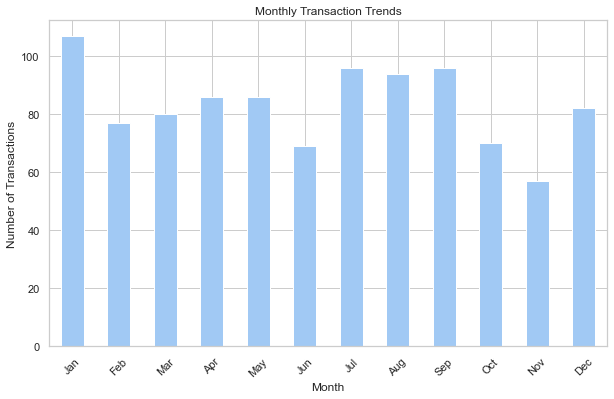

Transaction volumes peak during month 1.


In [18]:
display(HTML("<h2>Insight 4: Seasonal Trends in Transactions</h2>"
             "<p><b>Business Insight:</b> Transaction volumes peak during January, suggesting seasonality in customer purchases. This information can guide inventory planning and marketing campaigns.</p>"))


# Extract month from transaction dates
transactions['TransactionMonth'] = transactions['TransactionDate'].dt.month

# Group by month to find trends
monthly_transactions = transactions.groupby('TransactionMonth')['TransactionID'].count()

# Plot
monthly_transactions.plot(kind='bar')
plt.title('Monthly Transaction Trends')
plt.xlabel('Month')
plt.ylabel('Number of Transactions')
plt.xticks(ticks=range(12), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                                    'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], rotation=45)
plt.show()

# Insight
top_month = monthly_transactions.idxmax()
print(f"Transaction volumes peak during month {top_month}.")


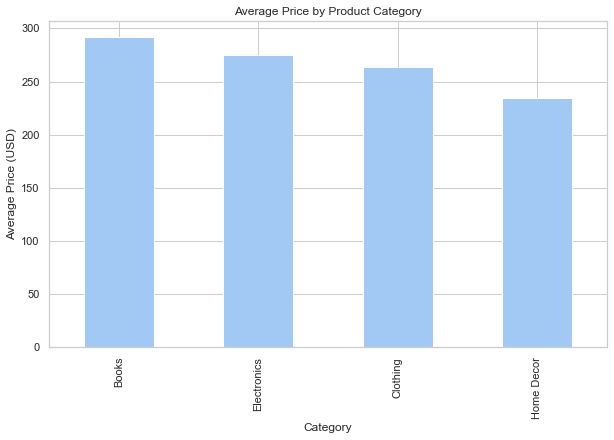

'Books' has the highest average price ($292.21), while 'Home Decor' has the lowest ($235.02).


In [19]:
display(HTML("<h2>Insight 5: Price Sensitivity by Product Category</h2>"
             "<p><b>Business Insight:</b> Products in [Books] have the highest average price, while [Home Decor] has the lowest. This suggests that premium pricing strategies can be applied selectively.</p>"))


# Average price per category
category_avg_price = products.groupby('Category')['Price'].mean().sort_values(ascending=False)

# Plot
category_avg_price.plot(kind='bar')
plt.title('Average Price by Product Category')
plt.xlabel('Category')
plt.ylabel('Average Price (USD)')
plt.show()

# Insight
print(f"'{category_avg_price.idxmax()}' has the highest average price (${category_avg_price.max():.2f}), while '{category_avg_price.idxmin()}' has the lowest (${category_avg_price.min():.2f}).")


In [52]:
from IPython.core.display import display, HTML

html_content = """
<h1>Task 2: Lookalike Model</h1>


<p>Build a Lookalike Model that takes a user's information as input and recommends 3 similar customers based on their profile and transaction history. The model should:
● Use both customer and product information.
● Assign a similarity score to each recommended customer.</p>
"""

display(HTML(html_content))
import pandas as pd

# Load datasets
customers = pd.read_csv("Customers.csv")
transactions = pd.read_csv("Transactions.csv")
products = pd.read_csv("Products.csv")



# Merge transactions with customer and product information
data = transactions.merge(customers, on="CustomerID", how="left").merge(products, on="ProductID", how="left")

# Verify the merged data structure
# print("Merged Data Columns:", data.columns)
# print(data.head())

# Check for valid columns before aggregation
required_columns = ["TotalValue", "Quantity", "Category"]
missing_columns = [col for col in required_columns if col not in data.columns]
if missing_columns:
    print(f"Warning: Missing columns for aggregation: {missing_columns}")

# Perform aggregation on available columns
customer_profile = data.groupby("CustomerID").agg({
    "TotalValue": "sum",        # Total spending
    "Quantity": "sum",          # Total quantity purchased
    "Category": lambda x: ','.join(x.dropna().unique()),  # Unique product categories
}).reset_index()

# print(customer_profile.head())

from sklearn.preprocessing import LabelEncoder

# Encode categorical features (e.g., Category)
if "Category" in customer_profile.columns:
    encoder = LabelEncoder()
    customer_profile["Category"] = encoder.fit_transform(customer_profile["Category"])

# Check if 'TotalValue' exists; if not, calculate it
if "TotalValue" not in data.columns:
    data["TotalValue"] = data["Quantity"] * data["Price"]

# Perform aggregation
customer_profile = data.groupby("CustomerID").agg({
    "TotalValue": "sum",         # Total spending
    "Quantity": "sum",           # Total quantity purchased
    "Category": lambda x: ','.join(x.dropna().unique()),  # Unique product categories
}).reset_index()

# Verify columns
print("Updated Customer Profile Columns:", customer_profile.columns)
# Ensure "Category" is encoded only if it exists
if "Category" in customer_profile.columns:
    from sklearn.preprocessing import LabelEncoder
    encoder = LabelEncoder()
    customer_profile["Category"] = encoder.fit_transform(customer_profile["Category"])
else:
    print("Warning: 'Category' column not found in customer_profile.")

# Select features for similarity computation (check for column existence)
valid_features = [col for col in ["TotalValue", "Quantity", "Category"] if col in customer_profile.columns]

if not valid_features:
    raise ValueError("No valid columns found for similarity computation.")

features = customer_profile[valid_features]

# Compute cosine similarity
from sklearn.metrics.pairwise import cosine_similarity
similarity_matrix = cosine_similarity(features)

# Convert to DataFrame
similarity_df = pd.DataFrame(similarity_matrix, index=customer_profile["CustomerID"], columns=customer_profile["CustomerID"])

# print("Customer Profile Columns:", customer_profile.columns)
# print(customer_profile.head())
valid_features = [col for col in ["TotalValue", "Quantity", "Category"] if col in customer_profile.columns]

if not valid_features:
    raise ValueError("No valid columns found for similarity computation.")
similarity_matrix = cosine_similarity(features)

# Convert to DataFrame
similarity_df = pd.DataFrame(similarity_matrix, index=customer_profile["CustomerID"], columns=customer_profile["CustomerID"])
print(similarity_df)

C:\Users\Ankit Pandey\AppData\Local\Temp\ipykernel_9032\872038179.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


Updated Customer Profile Columns: Index(['CustomerID', 'TotalValue', 'Quantity', 'Category'], dtype='object')
CustomerID     C0001     C0002     C0003     C0004     C0005     C0006  \
CustomerID                                                               
C0001       1.000000  0.999742  0.999888  0.999999  0.999761  0.999999   
C0002       0.999742  1.000000  0.999970  0.999706  0.999998  0.999709   
C0003       0.999888  0.999970  1.000000  0.999864  0.999974  0.999866   
C0004       0.999999  0.999706  0.999864  1.000000  0.999725  0.999999   
C0005       0.999761  0.999998  0.999974  0.999725  1.000000  0.999730   
...              ...       ...       ...       ...       ...       ...   
C0196       0.999994  0.999657  0.999829  0.999997  0.999681  0.999998   
C0197       0.999728  1.000000  0.999965  0.999691  0.999998  0.999695   
C0198       0.999443  0.999940  0.999828  0.999389  0.999934  0.999398   
C0199       0.999879  0.999974  1.000000  0.999854  0.999979  0.999856   
C0

Merged Data Columns: Index(['TransactionID', 'CustomerID', 'ProductID', 'TransactionDate',
       'Quantity', 'TotalValue', 'Price_x', 'CustomerName', 'Region',
       'SignupDate', 'ProductName', 'Category', 'Price_y'],
      dtype='object')
  TransactionID CustomerID ProductID      TransactionDate  Quantity  \
0        T00001      C0199      P067  2024-08-25 12:38:23         1   
1        T00112      C0146      P067  2024-05-27 22:23:54         1   
2        T00166      C0127      P067  2024-04-25 07:38:55         1   
3        T00272      C0087      P067  2024-03-26 22:55:37         2   
4        T00363      C0070      P067  2024-03-21 15:10:10         3   

   TotalValue  Price_x     CustomerName         Region  SignupDate  \
0      300.68   300.68   Andrea Jenkins         Europe  2022-12-03   
1      300.68   300.68  Brittany Harvey           Asia  2024-09-04   
2      300.68   300.68  Kathryn Stevens         Europe  2024-04-04   
3      601.36   300.68  Travis Campbell  South Ame

C:\Users\Ankit Pandey\AppData\Local\Temp\ipykernel_9032\447758777.py:9: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


D:\BOOKS\anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
D:\BOOKS\anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Index(['TransactionID', 'CustomerID', 'ProductID', 'TransactionDate',
       'Quantity', 'TotalValue', 'Price', 'CustomerName', 'Region',
       'SignupDate'],
      dtype='object')
  CustomerID  TotalValue  Quantity       Price
0      C0001     3354.52        12  278.334000
1      C0002     1862.74        10  208.920000
2      C0003     2725.38        14  195.707500
3      C0004     5354.88        23  240.636250
4      C0005     2034.24         7  291.603333


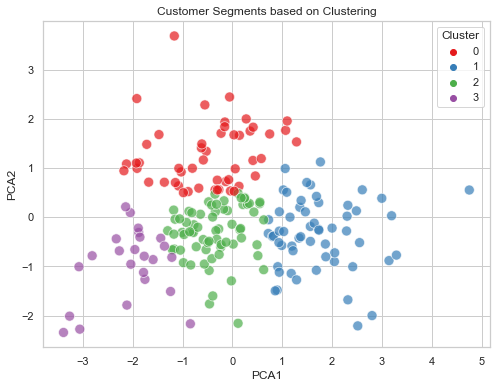

Davies-Bouldin Index: 0.9448437495439578
Silhouette Score: 0.33071125179757666


In [53]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import davies_bouldin_score, silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.core.display import display, HTML

html_content = """
<h1>Task 3 : Customer Segmentation Using Clustering</h1>

<p>This analysis performs customer segmentation using clustering techniques, combining customer profile and transaction data. The goal is to group customers based on similar behaviors to enable targeted marketing strategies. We apply the KMeans algorithm and evaluate the results using clustering metrics such as the Davies-Bouldin Index.</p>
"""

display(HTML(html_content))

# Load the data (replace with actual file paths)
customers = pd.read_csv('Customers.csv')
transactions = pd.read_csv('Transactions.csv')

# Merge customer profile and transaction data
data = transactions.merge(customers, on="CustomerID", how="left")

# Check the columns in the merged data
print(data.columns)

# Modify the aggregation based on available columns
if 'Category' in data.columns:
    customer_profile = data.groupby("CustomerID").agg({
        "TotalValue": "sum",   # Total spending
        "Quantity": "sum",     # Total quantity purchased
        "Price": "mean",       # Average product price
        "Category": lambda x: ','.join(x.unique()),  # Unique product categories
    }).reset_index()
else:
    customer_profile = data.groupby("CustomerID").agg({
        "TotalValue": "sum",   # Total spending
        "Quantity": "sum",     # Total quantity purchased
        "Price": "mean",       # Average product price
    }).reset_index()

# Check the resulting customer profile data
print(customer_profile.head())

# Standardize the features
scaler = StandardScaler()
features = customer_profile[["TotalValue", "Quantity", "Price"]]
scaled_features = scaler.fit_transform(features)

# Perform PCA for dimensionality reduction (optional, for visualization)
pca = PCA(n_components=2)
pca_components = pca.fit_transform(scaled_features)

# Choose the number of clusters (let's use KMeans for clustering)
kmeans = KMeans(n_clusters=4, random_state=42)  # You can try different numbers of clusters
customer_profile['Cluster'] = kmeans.fit_predict(scaled_features)

# Add PCA components for visualization
customer_profile['PCA1'] = pca_components[:, 0]
customer_profile['PCA2'] = pca_components[:, 1]

# Visualize the clusters using a scatter plot
plt.figure(figsize=(8, 6))
sns.scatterplot(data=customer_profile, x='PCA1', y='PCA2', hue='Cluster', palette='Set1', s=100, alpha=0.7)
plt.title('Customer Segments based on Clustering')
plt.show()

# Evaluate clustering performance using Davies-Bouldin Index and Silhouette Score
db_index = davies_bouldin_score(scaled_features, customer_profile['Cluster'])
silhouette = silhouette_score(scaled_features, customer_profile['Cluster'])

# Print clustering metrics
print(f'Davies-Bouldin Index: {db_index}')
print(f'Silhouette Score: {silhouette}')

# Save the clustered data to a new CSV file (optional)
customer_profile.to_csv('Customer_Segmentation_Clusters.csv', index=False)


SyntaxError: invalid syntax (2509071951.py, line 1)

Updated Customer Profile Columns: Index(['CustomerID', 'TotalValue', 'Quantity', 'Category'], dtype='object')


Customer Profile Columns: Index(['CustomerID', 'TotalValue', 'Quantity', 'Category'], dtype='object')
  CustomerID  TotalValue  Quantity  Category
0      C0001     3354.52        12        14
1      C0002     1862.74        10        50
2      C0003     2725.38        14        52
3      C0004     5354.88        23        14
4      C0005     2034.24         7        53


C:\Users\Ankit Pandey\AppData\Local\Temp\ipykernel_9032\447758777.py:9: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


D:\BOOKS\anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
D:\BOOKS\anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Index(['TransactionID', 'CustomerID', 'ProductID', 'TransactionDate',
       'Quantity', 'TotalValue', 'Price', 'CustomerName', 'Region',
       'SignupDate'],
      dtype='object')
  CustomerID  TotalValue  Quantity       Price
0      C0001     3354.52        12  278.334000
1      C0002     1862.74        10  208.920000
2      C0003     2725.38        14  195.707500
3      C0004     5354.88        23  240.636250
4      C0005     2034.24         7  291.603333


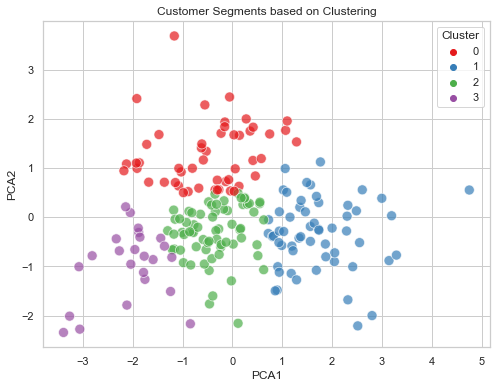

Davies-Bouldin Index: 0.9448437495439578
Silhouette Score: 0.33071125179757666
